Customer Churn Prediction

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
plt.style.use('seaborn-dark-palette')

C:\Users\Michelle\AppData\Local\Temp\ipykernel_19988\3139073677.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score, recall_score, precision_recall_curve, auc, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [30]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import save_model
import scikeras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [31]:
# !pip install scikeras

Load dfs

In [32]:
with open('df_train.pkl', 'rb') as file:
    df_train = pickle.load(file)

df_train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [33]:
with open('df_test.pkl', 'rb') as file:
    df_test = pickle.load(file)

df_test.head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [34]:
with open('df_test_2.pkl', 'rb') as file:
    df_test_2 = pickle.load(file)

df_test_2.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,62,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,93,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,174,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


Preprocessing and Modeling

In [35]:
def model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


class lstm_model:

    def __init__(self, data):
        self.data = data
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = None
        self.model = None
        

    def load(self):
        self.data = pd.read_csv(self.data_path)
        

    def preprocess(self):
        X = self.data.drop(["churn"], axis=1)
        y = self.data["churn"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        self.X_train = np.reshape(self.X_train, (self.X_train.shape[0], 1, self.X_train.shape[1]))
        self.X_test = np.reshape(self.X_test, (self.X_test.shape[0], 1, self.X_test.shape[1]))
        

    def build(self):
        self.model = Sequential()
        self.model.add(LSTM(64, input_shape=(1, self.X_train.shape[2]), return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(32))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    def early_stop(self, patience=10, restore_best_weights=True):
        return EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=restore_best_weights)
    

    def custom(self, y_true, y_pred):
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
        return balanced_accuracy
    

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
        y_pred_prob = self.model.predict(X_reshaped)
        y_pred_round = np.round(y_pred_prob)
        y_pred = y_pred_round.astype(int).ravel()
        return y_pred


    def save(self, model_path):
        self.model.save(model_path)


    def load(self, model_path):
        self.model = load_model(model_path)


    def predict_probability(self, X):
        X_scaled = self.scaler.transform(X)
        X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
        y_pred_prob = self.model.predict(X_reshaped)
        return y_pred_prob


    def train_val_split(self, val_size=0.1, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, self.y_train, test_size=val_size, random_state=random_state)
        self.X_val = np.reshape(self.X_val, (self.X_val.shape[0], 1, self.X_train.shape[2]))


    def learning_rate_reduction(self, factor=0.1, patience=10, min_lr=1e-5):
        return ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=min_lr)


    def train(self, epochs, batch_size, use_early_stopping=True, use_lr_reduction=True):
        callbacks = []
        if use_early_stopping:
            callbacks.append(self.early_stop())
        if use_lr_reduction:
            callbacks.append(self.learning_rate_reduction())
        history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
                                 validation_data=(self.X_test, self.y_test), callbacks=callbacks)
        return history


In [36]:
lstm_classifier = lstm_model(df_train)
lstm_classifier.preprocess()
lstm_classifier.train_val_split()
lstm_classifier.build()
history = lstm_classifier.train(epochs=1000, batch_size=64)

Epoch 1/1000
48/48 [==============================] - 8s 29ms/step - loss: 0.6422 - accuracy: 0.8428 - val_loss: 0.5667 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 2/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.4388 - accuracy: 0.8647 - val_loss: 0.3467 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 3/1000
48/48 [==============================] - 0s 5ms/step - loss: 0.3122 - accuracy: 0.8683 - val_loss: 0.3149 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 4/1000
48/48 [==============================] - 0s 5ms/step - loss: 0.2887 - accuracy: 0.8778 - val_loss: 0.2963 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.2706 - accuracy: 0.8889 - val_loss: 0.2732 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 6/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.2494 - accuracy: 0.9072 - val_loss: 0.2568 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 7/1000
48/48 [==============================] - 0s 5ms/step - l

Prediction

In [40]:
y_pred_prob = lstm_classifier.predict_probability(df_test_2)

24/24 [==============================] - 1s 4ms/step


In [41]:
predicted = lstm_classifier.predict(df_test_2)

24/24 [==============================] - 0s 1ms/step


In [43]:
id = df_test.id

outcome = pd.DataFrame({'id':id, 'churn':predicted})
outcome.head(5)

,id,churn
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
outcome.churn.replace([0,1],['no','yes'], inplace=True)

In [47]:
outcome.churn.value_counts()

no     662
yes     88
Name: churn, dtype: int64

In [48]:
def predict_churn():
    user_input = {
        'account_length': int(input("Enter account length: ")),
        'international_plan': input("International plan (yes/no): "),
        'voice_mail_plan': input("Voice mail plan (yes/no): "),
        'number_vmail_messages': int(input("Enter number of voicemail messages: ")),
        'total_day_minutes': float(input("Enter total day minutes: ")),
        'total_day_calls': int(input("Enter total day calls: ")),
        'total_day_charge': float(input("Enter total day charge: ")),
        'total_eve_minutes': float(input("Enter total evening minutes: ")),
        'total_eve_calls': int(input("Enter total evening calls: ")),
        'total_eve_charge': float(input("Enter total evening charge: ")),
        'total_night_minutes': float(input("Enter total night minutes: ")),
        'total_night_calls': int(input("Enter total night calls: ")),
        'total_night_charge': float(input("Enter total night charge: ")),
        'total_intl_minutes': float(input("Enter total international minutes: ")),
        'total_intl_calls': int(input("Enter total international calls: ")),
        'total_intl_charge': float(input("Enter total international charge: ")),
        'number_customer_service_calls': int(input("Enter number of customer service calls: "))
    }

    user_df = pd.DataFrame([user_input])

    label_enc = LabelEncoder()
    columns_to_encode = ['international_plan', 'voice_mail_plan']
    for col in columns_to_encode:
        user_df[col] = label_enc.fit_transform(user_df[col])

    user_features = user_df
    user_features_scaled = lstm_classifier.scaler.transform(user_features)
    user_features_scaled_reshaped = np.reshape(user_features_scaled,
                                              (user_features_scaled.shape[0], 1, user_features_scaled.shape[1]))

    prediction = lstm_classifier.model.predict(user_features_scaled_reshaped)

    if prediction[0][0] > 0.5: 
        print("Churn is predicted")
    else:
        print("No churn is predicted")

In [49]:
predict_churn()

1/1 [==============================] - 0s 17ms/step
Churn is predicted


Evaluation

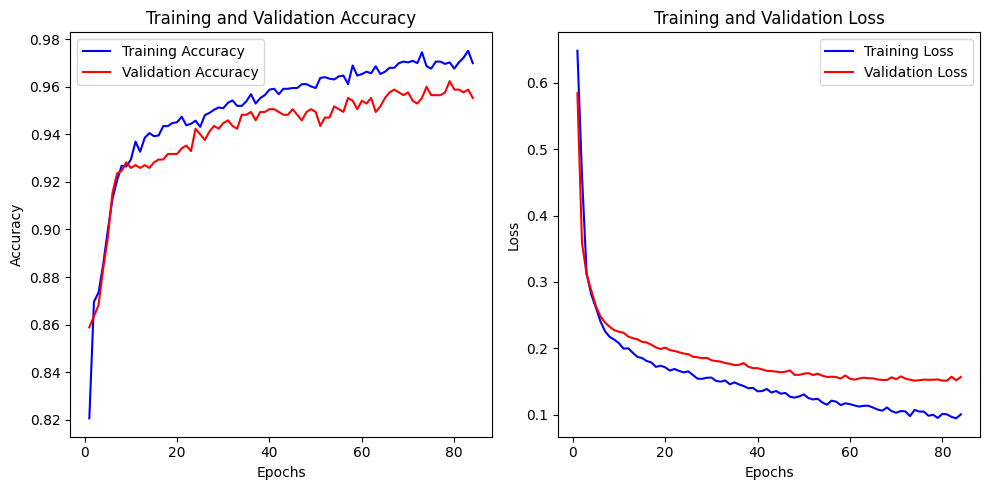

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred_round = np.round(y_pred_prob)
    y_pred = y_pred_round.astype(int).ravel()

    classification_report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(classification_report)
    return classification_report

classification_report = evaluate_model(lstm_classifier.model, lstm_classifier.X_val, lstm_classifier.y_val)

11/11 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       285
           1       0.92      0.65      0.77        55

    accuracy                           0.94       340
   macro avg       0.93      0.82      0.86       340
weighted avg       0.93      0.94      0.93       340



11/11 [==============================] - 0s 2ms/step


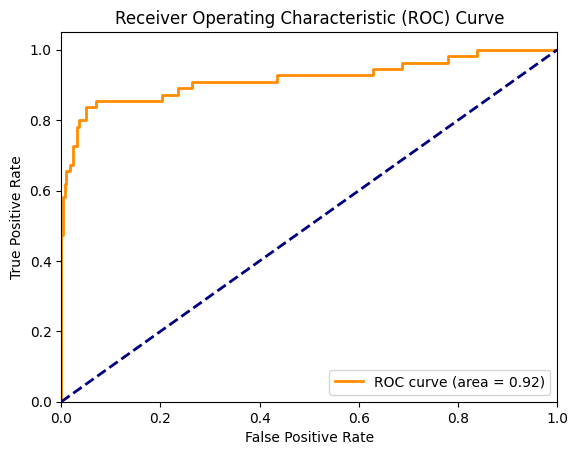

In [ ]:
def plot_roc_curve(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(lstm_classifier.model, lstm_classifier.X_val, lstm_classifier.y_val)

Saving model

In [ ]:
# Save the model to disk
lstm_classifier.save_model('CustomerChurn.h5')